#**problem Statement**

In natural language processing (NLP), **Part of Speech (POS)** refers to **the grammatical category** or syntactic function that a word serves in a sentence. It's a way of categorizing words based on their roles within the structure of a sentence. POS tagging involves assigning a specific label, such as **noun**, **verb**, **adjective**, **adverb**, etc., to each word in a sentence.

Here are some common parts of speech:

| Tag              | Arabic Tag | Description |
| :---------------- | ------: | :---- |
| Noun (N)        |   اسم   | Represents a person, place, thing, or idea. Examples: dog, city, happiness. |
| Verb (V)           |   فعل   | Describes an action or occurrence. Examples: run, eat, sleep. |
| Adjective (ADJ)    |  صفة   | Modifies or describes a noun. Examples: happy, tall, red. |
| Adverb (ADV) |  حال   | Modifies or describes a verb, adjective, or other adverb. Examples: quickly, very, well. |
| Pronoun (PRON) |  ضمير   | Replaces a noun. Examples: he, she, it. |
| Preposition (PREP) |  حرف جر   | Indicates relationships between words, often in terms of time or place. Examples: in, on, under. |
| Conjunction (CONJ) |  اقتران   | Connects words, phrases, or clauses. Examples: and, but, or. |
| Interjection (INTJ) |  تعجب   | Expresses strong emotion. Examples: wow, oh, ouch. |


**POS tagging** is an essential task in NLP because understanding the grammatical structure of a sentence helps machines comprehend the meaning and context of the text. It's particularly useful in applications like text analysis, information retrieval, and language translation.

#**Required packages**

In [4]:
!pip install networkx transformers accelerate seqeval datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=602c2a907dd3bce3f05cc081dafcd3edc6e8d903d778b92189ca96e1e6449323
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency 

In [5]:
import ast
import requests
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from seqeval.metrics import f1_score, accuracy_score

import networkx as nx

import torch
from torch.nn.functional import cross_entropy

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import (AutoTokenizer, XLMRobertaForTokenClassification,
                          Trainer, TrainingArguments, AutoConfig,
                          DataCollatorForTokenClassification)

#**Dataset investigation**

The [Arabic-PADT UD](https://github.com/UniversalDependencies/UD_Arabic-PADT) treebank is based on the Prague Arabic Dependency Treebank (PADT), created at the Charles University in Prague.

The treebank consists of 7,664 sentences (282,384 tokens) and its domain is mainly newswire. The annotation is licensed under the terms of CC BY-NC-SA 3.0 and its original (non-UD) version can be downloaded from http://hdl.handle.net/11858/00-097C-0000-0001-4872-3.

The morphological and syntactic annotation of the Arabic UD treebank is created through conversion of PADT data. The conversion procedure has been designed by Dan Zeman. The main coordinator of the original PADT project was Otakar Smrž.

Here is the first sample from the `ar_padt-ud-test.conllu` file:
```
# newdoc id = assabah.20041005.0017<br>
# newpar id = assabah.20041005.0017:p1<br>
# sent_id = assabah.20041005.0017:p1u1<br>
# text = <br>سوريا: تعديل وزاري واسع يشمل 8 حقائب
# orig_file_sentence ASB_ARB_20041005.0017#1<br>
1	سوريا	سُورِيَا	X	X---------	Foreign=Yes	0	root	0:root	SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=sUr|Translit=sūriyā|LTranslit=sūriyā<br>
2	:	:	PUNCT	G---------	_	1	punct	1:punct	Vform=:|Translit=:<br>
3	تعديل	تَعدِيل	NOUN	N------S1I	Case=Nom|Definite=Ind|Number=Sing	6	nsubj	6:nsubj<br>	Vform=تَعدِيلٌ|Gloss=adjustment,change,modification,amendment|Root=_d_l|Translit=taʿdīlun|LTranslit=tadīl<br>
4	وزاري	وِزَارِيّ	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod<br>	Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Root=w_z_r|Translit=wizārīyun|LTranslit=wizārīy<br>
5	واسع	وَاسِع	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod<br>	Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=w_s_|Translit=wāsiʿun|LTranslit=wāsi<br>
6	يشمل	شَمِل	VERB	VIIA-3MS--	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Person=3|VerbForm=Fin|Voice=Act	1	parataxis	1:parataxis<br>	Vform=يَشمَلُ|Gloss=comprise,include,contain|Root=^s_m_l|Translit=yašmalu|LTranslit=šamil<br>
7	8	8	NUM	Q---------	NumForm=Digit	6	obj	6:obj	Vform=٨|Translit=8<br>
8	حقائب	حَقِيبَة	NOUN	N------P2I	Case=Gen|Definite=Ind|Number=Plur	7	nmod	7:nmod:gen<br>	Vform=حَقَائِبَ|Gloss=briefcase,suitcase,portfolio,luggage|Root=.h_q_b|Translit=ḥaqāʾiba|LTranslit=ḥaqībat<br>


In [10]:
# the links of the dataset files
dataset_splits = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-train.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-test.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-dev.conllu",
}

# These are the standard column names for these `conllu` files
columns = ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]


def get_dataframe_of_split(split):
    """
    Download and convert the `split` file to a pandas `DataFrame`

    Parameters
    ----------
    - split : str
        A string represents the name of a particular dataset
        `split` ("train", "test", "dev").

    Returns
    -------
    - df : pd.DataFrame
        A pandas dataframe of the particular `split`.
    """

    # Download the datafile
    response = requests.get(dataset_splits[split])
    conllu_data = response.text
    lines = conllu_data.split('\n')
    data = []

    # Add a new column to the above columns `SENTENCE_ID` which can
    # tell us which words related to same sentence
    sentence_id = 0
    for line in lines:
        if line.startswith("# sent_id"):
            sentence_id += 1
        elif line.startswith("#") or line.strip() == "":
            continue
        else:
            values = line.split('\t')
            values.append(sentence_id)
            data.append(values)

    df = pd.DataFrame(data, columns=columns + ["SENTENCE_ID"])

    return df

In [11]:
# Download all the `dataset_splits`
train_df = get_dataframe_of_split("train")
test_df = get_dataframe_of_split("test")
dev_df = get_dataframe_of_split("dev")

In [10]:
train_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,برلين,بَرلِين,X,X---------,Foreign=Yes,2,nsubj,2:nsubj,Vform=بَرلِين|Gloss=Berlin|Root=barlIn|Transli...,1
1,2,ترفض,رَفَض,VERB,VIIA-3FS--,Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Per...,0,root,0:root,"Vform=تَرفُضُ|Gloss=reject,refuse|Root=r f .d|...",1
2,3,حصول,حُصُول,NOUN,N------S4R,Case=Acc|Definite=Cons|Number=Sing,2,obj,2:obj,"Vform=حُصُولَ|Gloss=acquisition,obtaining,occu...",1
3,4,شركة,شَرِكَة,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,3,nmod,3:nmod:gen,"Vform=شَرِكَةٍ|Gloss=company,corporation|Root=...",1
4,5,اميركية,أَمِيرِكِيّ,ADJ,A-----FS2I,Case=Gen|Definite=Ind|Gender=Fem|Number=Sing,4,amod,4:amod,Vform=أَمِيرِكِيَّةٍ|Gloss=American|Root='amIr...,1


In [12]:
train_df.tail()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
254379,33,بنية,بِنيَة,NOUN,N------S1R,Case=Nom|Definite=Cons|Number=Sing,32,nmod,32:nmod:nom,"Gloss=structure,make_-_up|LTranslit=binyat|Roo...",6075
254380,34,ه,هُوَ,PRON,SP---3MS2-,Case=Gen|Gender=Masc|Number=Sing|Person=3|Pron...,33,nmod,33:nmod:gen,"Gloss=he,she,it|LTranslit=huwa|Translit=hu|Vfo...",6075
254381,35,التحتية,تَحتِيّ,ADJ,A-----FS2D,Case=Gen|Definite=Def|Gender=Fem|Number=Sing,33,amod,33:amod,SpaceAfter=No|Vform=اَلتَّحتِيَّةِ|Gloss=lower...,6075
254382,36,"""","""",PUNCT,G---------,_,25,punct,25:punct,"SpaceAfter=No|Vform=""|Translit=""",6075
254383,37,.,.,PUNCT,G---------,_,1,punct,1:punct,Vform=.|Translit=.,6075


In [13]:
len(train_df)

254384

As we can see, the train dataset consists of **254400** row and **11** columns. Each row corresponds to one word.

| Column | Status |
| ------ | ------ |
| ID | Sentence-level units in PADT often correspond to entire paragraphs and they were obtained automatically. Low-level tokenization (whitespace and punctuation) was done automatically and then hand-corrected. Splitting of fused tokens into syntactic words in Arabic is part of morphological analysis. [ElixirFM](http://elixir-fm.sf.net/) was used to provide context-independent options, then these results were disambiguated manually. |
| FORM | The unvocalized surface form is used. Fully vocalized counterpart can be found in the MISC column as Vform attribute. |
| LEMMA | Plausible analyses provided by ElixirFM, manual disambiguation. Lemmas are vocalized. Part of the selection of lemmas was also word sense disambiguation of the lexemes, providing English equivalents (see the Gloss attribute of the MISC column). |
| UPOSTAG | Converted automatically from XPOSTAG (via [Interset](http://ufal.mff.cuni.cz/interset)); human checking of patterns revealed by automatic consistency tests. |
| XPOSTAG | Manual selection from possibilities provided by ElixirFM. |
| FEATS | Converted automatically from XPOSTAG (via Interset); human checking of patterns revealed by automatic consistency tests. |
| HEAD | Original PADT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPREL | Original PDT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPS | &mdash; (currently unused) |
| MISC | Information about token spacing taken from PADT annotation. Additional word attributes provided by morphological analysis (i.e. ElixirFM rules + manual disambiguation): Vform (fully vocalized Arabic form), Translit (Latin transliteration of word form), LTranslit (Latin transliteration of lemma), Root (word root), Gloss (English translation of lemma). |

##**Feature Selection**
 select only the columns that is useful for POS tagging
* [sentence_id, id, form, upos]
* In addition to changing these columns names to be more readable.



In [14]:
column_mapper = {
    "SENTENCE_ID": "sentence_id",
    "ID": "id",
    "FORM": "word",
    "UPOS": "tag",
}

train_df = train_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
test_df = test_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
dev_df = dev_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)

In [15]:
train_df.head()


,sentence_id,id,word,tag
0,1,1,برلين,X
1,1,2,ترفض,VERB
2,1,3,حصول,NOUN
3,1,4,شركة,NOUN
4,1,5,اميركية,ADJ


##**Unique labels**
useful for future functions

In [16]:
unique_labels = train_df["tag"].unique().tolist()
print(f"There are {len(unique_labels)} unique label:\n{unique_labels}")

There are 18 unique label:
['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ']


##**convert words of same sentence to be one sentence**

* train_df.groupby(["sentence_id"])
Groups the rows of train_df by the unique values in the sentence_id column. Each group corresponds to a unique sentence_id.

* [["word", "tag"]]
Specifies that only the word and tag columns will be considered for aggregation.

* .agg(list)
Applies the list function to each group. This collects all values in the word and tag columns for each group into lists.

* .reset_index()
Converts the grouped result back into a DataFrame, where sentence_id becomes a regular column instead of an index.

```python
import pandas as pd

data = {
    "sentence_id": [1, 1, 1, 2, 2],
    "word": ["The", "quick", "fox", "jumps", "over"],
    "tag": ["DET", "ADJ", "NOUN", "VERB", "PREP"],
}
train_df = pd.DataFrame(data)
```
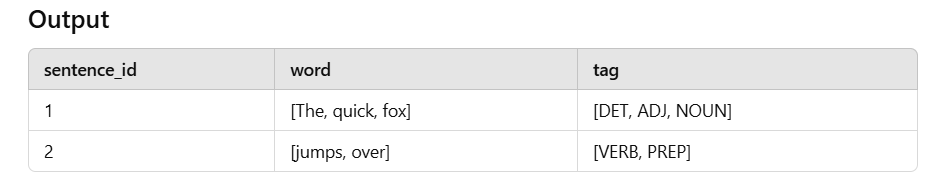

In [17]:
grouped_train_df = train_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_test_df = test_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_dev_df = dev_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()

In [18]:
# Rename the columns to be representative
agg_column_mapper = {
    "word": "text",
    "tag": "tags"
}

grouped_train_df.rename(columns=agg_column_mapper, inplace=True)
grouped_test_df.rename(columns=agg_column_mapper, inplace=True)
grouped_dev_df.rename(columns=agg_column_mapper, inplace=True)

grouped_train_df.head()

,sentence_id,text,tags
0,1,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO..."
1,2,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT..."
2,3,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUNCT,..."
3,4,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB, A..."
4,5,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NOUN,..."


 we ended up with a row for each sentence : thier corresponfing text and tags values



##**Save final Data**

In [19]:
grouped_train_df.to_csv("train_dataset.csv", index=0)
grouped_test_df.to_csv("test_dataset.csv", index=0)
grouped_dev_df.to_csv("dev_dataset.csv", index=0)

In [17]:
train_dataset = load_dataset("csv", data_files="/content/train_dataset.csv")
test_dataset = load_dataset("csv", data_files="/content/test_dataset.csv")
dev_dataset = load_dataset("csv", data_files="/content/dev_dataset.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

##**Loading Dataset from drive for easy restart**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Arabic-pos/train_dataset.csv")
test_dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Arabic-pos/test_dataset.csv")
dev_dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Arabic-pos/dev_dataset.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
train_dataset = train_dataset["train"]
test_dataset = test_dataset["train"]
dev_dataset = dev_dataset["train"]

dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "dev": dev_dataset})

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 909
    })
})

##**Create Classlabel**

In [20]:
labels = ClassLabel(num_classes=len(unique_labels), names=unique_labels)
labels

ClassLabel(names=['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ'], id=None)

In [21]:
example = dataset["train"][0]
example

{'sentence_id': 1,
 'text': '[\'برلين\', \'ترفض\', \'حصول\', \'شركة\', \'اميركية\', \'على\', \'رخصة\', \'تصنيع\', \'دبابة\', \'"\', \'ليوبارد\', \'"\', \'الالمانية\']',
 'tags': "['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']"}

In [22]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'str'>
type of tags column: <class 'str'>


In [23]:
def convert_columns_to_lists(example):
    """
    Convert `example` columns to a `list` rather than a `string`.

    Parameters
    ----------
    - example : dict
        A dict represents a particular example of the dataset.

    Returns
    -------
    - dict
        A new dictionary corresponding of the new dataset columns
        after conversion.
    """

    return {'text': ast.literal_eval(example['text']), 'tags': ast.literal_eval(example['tags'])}

dataset = dataset.map(convert_columns_to_lists)

Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [24]:
example = dataset["train"][0]
example

{'sentence_id': 1,
 'text': ['برلين',
  'ترفض',
  'حصول',
  'شركة',
  'اميركية',
  'على',
  'رخصة',
  'تصنيع',
  'دبابة',
  '"',
  'ليوبارد',
  '"',
  'الالمانية'],
 'tags': ['X',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'ADP',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'X',
  'PUNCT',
  'ADJ']}

In [25]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'list'>
type of tags column: <class 'list'>


##**Convert label to index**

```python
from datasets import Dataset

# Sample dataset with class names
data = {"text": ["I love cats", "Dogs are great", "Birds fly high"],
        "label": ["cat", "dog", "bird"]}

dataset = Dataset.from_dict(data)

# Convert class names into indices
dataset = dataset.map(lambda x: {"label": class_labels.str2int(x["label"])})

print(dataset["label"])  # Outputs: [0, 1, 2]
```

In [26]:
def tags2index(example):
    """
    Create a new column called `pos_tags` that contains the
    integer representation for each tag.

    Parameters
    ----------
    - example : dict
        A dict represents a particular example of the dataset.

    Returns
    -------
    - dict
        A new dictionary corresponding the integer value for
        each tag in the `example`.
    """

    return {"pos_tags": labels.str2int(example["tags"])}



In [27]:
dataset = dataset.map(tags2index)


Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 909
    })
})

In [29]:
example = dataset["train"][0]
example

{'sentence_id': 1,
 'text': ['برلين',
  'ترفض',
  'حصول',
  'شركة',
  'اميركية',
  'على',
  'رخصة',
  'تصنيع',
  'دبابة',
  '"',
  'ليوبارد',
  '"',
  'الالمانية'],
 'tags': ['X',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'ADP',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'X',
  'PUNCT',
  'ADJ'],
 'pos_tags': [0, 1, 2, 2, 3, 4, 2, 2, 2, 5, 0, 5, 3]}

In [30]:
split2freqs = defaultdict(Counter)

for split, ds in dataset.items():
    for row in ds["tags"]:
        for tag in row:
            split2freqs[split][tag] += 1

pd.DataFrame.from_dict(split2freqs, orient="index").T

,train,test,dev
X,13747.0,1380.0,2041.0
VERB,16807.0,2191.0,2319.0
NOUN,74546.0,9547.0,9612.0
ADJ,23498.0,2937.0,2916.0
ADP,33617.0,4528.0,4410.0
PUNCT,17511.0,2052.0,2882.0
NUM,6010.0,779.0,969.0
_,30485.0,3865.0,4020.0
PRON,8533.0,1133.0,1211.0
SCONJ,4368.0,534.0,555.0


```python
pd.DataFrame.from_dict(split2freqs, orient="index").T

```
* orient="index": Treats keys (split names) as rows.
* .T: Transposes the DataFrame to make tag names the rows and splits the columns.

#**Tokenization**

We need a tokenizer of a represenative model like `BERT` to be trained on `Arabic` corpus , else tokenization will be `subtokens` for most of the words leading to a huge un alignments between the labels aka `tags` and the text aka `candidate word`:
* lets examine two diff
    * xlm-roberta tokenizer [FacebookAI/xlm-roberta-base](https://huggingface.co/FacebookAI/xlm-roberta-base)
    * BERT tokenizer [BERT-base-uncased](https://huggingface.co/google-bert/bert-base-uncased)  

In [32]:
dataset['train'][0]

{'sentence_id': 1,
 'text': ['برلين',
  'ترفض',
  'حصول',
  'شركة',
  'اميركية',
  'على',
  'رخصة',
  'تصنيع',
  'دبابة',
  '"',
  'ليوبارد',
  '"',
  'الالمانية'],
 'tags': ['X',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'ADP',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'X',
  'PUNCT',
  'ADJ'],
 'pos_tags': [0, 1, 2, 2, 3, 4, 2, 2, 2, 5, 0, 5, 3]}

In [44]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [45]:
text = "رفضت برلين ان ترفع الحصار من على ايطاليا"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(f"BERT tokens: \n{bert_tokens}\n")
print(f"XLMR tokens: \n{xlmr_tokens}\n")

BERT tokens: 
['[CLS]', 'ر', '##ف', '##ض', '##ت', 'ب', '##ر', '##ل', '##ي', '##ن', 'ا', '##ن', 'ت', '##ر', '##ف', '##ع', 'ا', '##ل', '##ح', '##ص', '##ا', '##ر', 'م', '##ن', 'ع', '##ل', '##ى', 'ا', '##ي', '##ط', '##ا', '##ل', '##ي', '##ا', '[SEP]']

XLMR tokens: 
['<s>', '▁رفض', 'ت', '▁بر', 'لين', '▁ان', '▁ت', 'رفع', '▁الح', 'صار', '▁من', '▁على', '▁اي', 'طال', 'يا', '</s>']



As we can see from the above generated tokens, XLM-R tokens are **dominant** to BERT tokens and this due that XLM-R is trained on a huge **multillingual corpus** of around **100** languages and Arabic is one of them, so we cann that `xlmr_tokenizer` can deal with the Arabic text much better than `bert_tokenizer`

In [34]:
index2tag = {idx: tag for idx, tag in enumerate(labels.names)}
tag2index = {tag: idx for idx, tag in enumerate(labels.names)}
index2tag, tag2index

({0: 'X',
  1: 'VERB',
  2: 'NOUN',
  3: 'ADJ',
  4: 'ADP',
  5: 'PUNCT',
  6: 'NUM',
  7: '_',
  8: 'PRON',
  9: 'SCONJ',
  10: 'CCONJ',
  11: 'DET',
  12: 'PART',
  13: 'ADV',
  14: 'SYM',
  15: 'AUX',
  16: 'PROPN',
  17: 'INTJ'},
 {'X': 0,
  'VERB': 1,
  'NOUN': 2,
  'ADJ': 3,
  'ADP': 4,
  'PUNCT': 5,
  'NUM': 6,
  '_': 7,
  'PRON': 8,
  'SCONJ': 9,
  'CCONJ': 10,
  'DET': 11,
  'PART': 12,
  'ADV': 13,
  'SYM': 14,
  'AUX': 15,
  'PROPN': 16,
  'INTJ': 17})

In [46]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=labels.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Input IDs,0,98747,368,1359,41882,716,746,68581,12011,20573,230,556,5669,76522,2796,2


we notice the problem of `subword tokenization` also encountered here

In [51]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")


Number of tokens in sequence: 16
Shape of outputs: torch.Size([1, 16, 18])


**[batch_size, sequence_length, number_of_classes]**

In [52]:
preds = [labels.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Tags,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,X,PART,PART


As we can see, we get a random tags of `PART` because the model does not know how to preform the task at our hands.

##**Putting all together**

In [55]:
def tag_text(text, tags, model, tokenizer):
    """
    Tokenize and predict the tags for given `text`.

    Parameters
    ----------
    - text : str
        A string for tokenization.
    - tags : datasets.ClassLabel
        A ClassLabel object for mapping tags to integers and vise versa.
    - model : transformers.XLMRobrtaForTokenClassification
        A PyTorch model for preforming token classification.
    - tokenizer : transformers.AutoTokenizer
        An AutoTokenizer associated with `model` for tokenizing `text`.

    Returns
    -------
    - pd.DataFrame
        A pandas dataframe contains input_tokens with their associated
        tags.
    """

    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 18 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=-1)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [58]:
text = "رفضت برلين ان ترفع الحصار من على ايطاليا"
tag_text(text, labels, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Tags,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,PART,X,PART,PART


In [64]:
example = dataset["test"][0]
tokens, labels, labels_name = example["text"], example["pos_tags"], example["tags"]

print(f"tokens: {tokens}")
print(f"labels: {labels}")
print(f"labels name: {labels_name}")

tokens: ['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب']
labels: [0, 5, 2, 3, 3, 1, 6, 2]
labels name: ['X', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'VERB', 'NUM', 'NOUN']


In [60]:
tokenized_input = xlmr_tokenizer(example["text"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>


In [61]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None


As we can see here using `word_ids()` methods returns the specific word id for each token, hence groupped tokens should have the same `word_id` number. E.g., `▁وز` and `اري` have the same word id which is **3** because they are belonging to the same word `(وزاري)` before tokenization.

##**Aligning of labels with tokens after subword tokenization**

In [62]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None
Label IDs,-100,0,5,2,3,-100,3,1,-100,-100,6,2,-100,-100
Labels,IGN,X,PUNCT,NOUN,ADJ,IGN,ADJ,VERB,IGN,IGN,NUM,NOUN,IGN,IGN


* This code is often used in token classification tasks (e.g., Named Entity Recognition, POS tagging) with models like BERT or similar, which tokenize input into subwords.
* It aligns the original word-level labels (labels) with the tokenized version (word_ids), ensuring that:
  * Tokens that are part of the same word or padding tokens are ignored (assigned a label of -100).
  * Each word gets the correct label for the first token representing it.


1. if word_idx is None or word_idx == previous_word_idx:
word_idx is None: Ignore tokens that do not correspond to any word (e.g., padding or special tokens).
* word_idx == previous_word_idx: Ignore subsequent subword tokens that belong to the same original word (only the first token of a word is labeled).
* Action: Append -100 to label_ids. The -100 is a special value often used in PyTorch to mask tokens during loss computation.
2. elif word_idx != previous_word_idx:
Indicates the start of a new word (the current token represents a new word).
Action: Append the label corresponding to word_idx from the labels list to label_ids.

**Note:**<br>
Why did I choose **–100** as the ID to mask subword representations? The reason is that in PyTorch the cross-entropy loss class
`torch.nn.CrossEntropyLoss` has an attribute called `ignore_index`
whose value is **–100**. This index is ignored during training, so we
can use it to ignore the tokens associated with consecutive
subwords

##**putting all together**

In [65]:
def tokenize_and_align_labels(examples):
    """
    Tokenize and align the labels for given `examples`.

    Parameters
    ----------
    - examples : dict
        A dictionary represents a single batch from the dataset.

    Returns
    -------
    - dict
        A dictionary contains the new `labels` value.
    """

    tokenized_inputs = xlmr_tokenizer(examples["text"], truncation=True,
                                      is_split_into_words=True)
    labels = []

    for idx, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [66]:
dataset_encoded = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=['text', 'sentence_id', 'pos_tags', 'tags'])


Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [67]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 909
    })
})

In [69]:
example = dataset_encoded["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

input_ids: [0, 1359, 41882, 746, 118947, 113825, 21215, 116414, 972, 648, 556, 37416, 58444, 6, 184142, 181, 28414, 250, 44, 7312, 7782, 71374, 44, 3484, 71095, 648, 2]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [-100, 0, -100, 1, -100, 2, 2, 3, -100, -100, 4, 2, -100, 2, -100, 2, -100, -100, 5, 0, -100, -100, 5, 3, -100, -100, -100]


#**finetuning**

##**Data collator**
A `data collator` is a utility in machine learning pipelines, particularly in NLP tasks, that prepares and batches data dynamically during training or evaluation. Its primary function is to take individual data samples (examples) and group them into a batch while ensuring that the batch meets the model's input requirements.

In [70]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)


##**Aligning predictions and ignoring -100**

In [71]:
def align_predictions(predictions, label_ids):
    """
    Convert `predictions` and `label_ids` to a list of lists
    which is the format that `seqeval` can deal with.

    Parameters
    ----------
    - predictions : np.ndarray
        A numpy array of predicitons.
    - label_ids : np.ndarray
        A numpy array of original label ids.

    Returns
    -------
    - tuple[list, list]
        Returns `preds_list` and `labels_list` which are a list of
        lists of the `predictions` and `label_ids`.
    """

    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

##**Evaluation metrics**

In [72]:
def compute_metrics(eval_pred):
    """
    Overriding the original `compute_metrics` function of
    the Trainer API.

    Parameters
    ----------
    - eval_pred : datasets.EvalPrediction
        An EvalPrediction object contains predictions and the
        original label_ids.

    Returns
    -------
    - dict
        A dictionary contains the specifc seqeval metrics needed
        to evaluate the model.
    """

    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)

    return {"f1": f1_score(y_true, y_pred), "accuracy": accuracy_score(y_true, y_pred)}

##**Training Args**

In [75]:
num_epochs = 3
batch_size = 2
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-ud-arabic"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    report_to="none")




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


##**Trainer**

In [76]:
trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["dev"],
    tokenizer=xlmr_tokenizer)

<ipython-input-76-74bd02949e6a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [77]:
trainer.train()


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.187100,0.122645,0.959432,0.971775
2,0.090100,0.093164,0.965941,0.976241
3,0.058500,0.096802,0.967874,0.977904


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NUM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: U

TrainOutput(global_step=9114, training_loss=0.11189561355707806, metrics={'train_runtime': 1464.93, 'train_samples_per_second': 12.441, 'train_steps_per_second': 6.221, 'total_flos': 817103828975148.0, 'train_loss': 0.11189561355707806, 'epoch': 3.0})

#**Testing pred**

In [78]:
predictions = trainer.predict(dataset_encoded["test"])
predictions.metrics

{'test_loss': 0.10909964889287949,
 'test_f1': 0.9638861803031646,
 'test_accuracy': 0.9744794746506489,
 'test_runtime': 5.6217,
 'test_samples_per_second': 120.961,
 'test_steps_per_second': 60.48}

#**Push to HF hub**


In [83]:
!pip install transformers huggingface_hub

In [85]:
from huggingface_hub import notebook_login

notebook_login()

In [87]:
trainer.push_to_hub("Commit Successfully")


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Mohamedsheded33/xlm-roberta-base-finetuned-ud-arabic/commit/8e7346dbb2e30c0c191fe2af8a28aa1cb9aa7b7e', commit_message='Commit Successfully', commit_description='', oid='8e7346dbb2e30c0c191fe2af8a28aa1cb9aa7b7e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mohamedsheded33/xlm-roberta-base-finetuned-ud-arabic', endpoint='https://huggingface.co', repo_type='model', repo_id='Mohamedsheded33/xlm-roberta-base-finetuned-ud-arabic'), pr_revision=None, pr_num=None)

In [88]:
from transformers import pipeline

pos_tagger = pipeline("token-classification", "Mohamedsheded33/xlm-roberta-base-finetuned-ud-arabic")

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [89]:
text = "اشترى خالد سيارة، و أصبح يمتلك 3 سيارات."

predictions = pos_tagger(text)


In [91]:
words = [item["word"] for item in predictions]
predicted_entities = [item["entity"] for item in predictions]


print(f"words:    {words}")
print(f"entites:  {predicted_entities}")

words:    ['▁اشتر', 'ى', '▁خالد', '▁سيارة', '،', '▁و', '▁أصبح', '▁يمتلك', '▁3', '▁سيارات', '.']
entites:  ['VERB', 'VERB', 'X', 'NOUN', 'PUNCT', 'CCONJ', 'VERB', 'VERB', 'NUM', 'NOUN', 'PUNCT']


#**Network X**

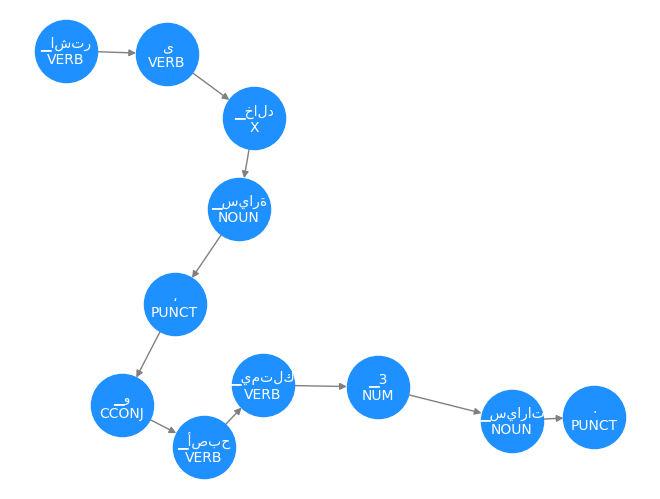

In [92]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i, word in enumerate(words):
    G.add_node(word, pos=predicted_entities[i])

# Add edges based on POS relationships
for i in range(len(words) - 1):
    G.add_edge(words[i], words[i+1])

# Plot the graph with labels
pos = nx.spring_layout(G)
node_labels = {node: f"{node}\n{G.nodes[node]['pos']}" for node in G.nodes}

nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color='dodgerblue', font_size=10, font_color='white', edge_color='gray')
plt.show()